In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
class Reshape(nn.Module):
    """
    A custom layer for reshaping input data.

    Args:
        channels (int): Number of output channels.
        n_h (int): Height of the reshaped output.
        n_w (int): Width of the reshaped output.
    """
    def __init__(self, channels, n_h, n_w):
        super(Reshape, self).__init__()
        self.channels = channels
        self.n_h = n_h
        self.n_w = n_w

    def __call__(self, x):
        """
        Forward pass of the reshaping layer.

        Args:
            x (Tensor): Input data tensor.

        Returns:
            Tensor: Reshaped output tensor.
        """
        self.out = x.reshape(x.shape[0], self.channels, self.n_h, self.n_w)
        return self.out

    def parameters(self):
        """
        Get the parameters of the layer.

        Returns:
            list: An empty list since this layer has no learnable parameters.
        """
        return []

class ConvolutionalEncoder(nn.Module):
    """
    A convolutional encoder network for a convolutional autoencoder.

    Args:
        in_channels (int): Number of input channels.
        n_h (int): Height of the input.
        n_w (int): Width of the input.
        n_layers (int): Number of layers in the encoder.
        layer_dims (list, optional): List of layer dimensions for the encoder.
    """
    def __init__(self, in_channels = 3, n_h = 64, n_w = 64, n_layers = 3, layer_dims = None):
        super(ConvolutionalEncoder, self).__init__()

        # If layer_dims is not provided, calculate default values.
        self.layer_dims = [16 * (n_h - 2) * (n_w - 2)] + layer_dims if layer_dims is not None else [16 * (n_h - 2) * (n_w - 2)] + [100 // 2**i for i in range(n_layers)]

        # Define layers for the encoder. First add the convolutional layers.
        layers = [[nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = 3, padding = 'same'),
                   nn.ReLU(),
                   nn.Dropout(.2),
                   nn.Conv2d(8, 16, kernel_size = 3, padding = 'same'),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 1),
                   nn.Flatten()]]

        # Add the linear layers.
        layers += [[nn.Linear(self.layer_dims[i], self.layer_dims[i+1]), nn.ReLU()] for i in range(len(self.layer_dims) - 1)]

        # Flatten the layers list.
        layers = sum(layers, [])

        # Create a sequential neural network with the defined layers.
        self.layers = nn.Sequential(*layers)

    def forward(self, X):
        """
        Forward pass of the convolutional encoder.

        Args:
            X (Tensor): Input data tensor.

        Returns:
            Tensor: Encoded representation of the input data.
        """
        out = self.layers(X)

        return out


class ConvolutionalDecoder(nn.Module):
    """
    A convolutional decoder network for a convolutional autoencoder.

    Args:
        out_channels (int): Number of output channels.
        n_h (int): Height of the output.
        n_w (int): Width of the output.
        n_layers (int): Number of layers in the decoder.
        layer_dims (list, optional): List of layer dimensions for the decoder.
    """
    def __init__(self, out_channels = 3, n_h = 64, n_w = 64, n_layers = 3, layer_dims = None):
        super(ConvolutionalDecoder, self).__init__()

        self.layer_dims = layer_dims + [16 * (n_h - 2) * (n_w - 2)] if layer_dims is not None else [100 // 2**i for i in range(n_layers)][::-1] + [16 * (n_h - 2) * (n_w - 2)]

        # Define layers for the encoder. First add the linear layers.
        layers = [[nn.Linear(self.layer_dims[i], self.layer_dims[i+1]), nn.ReLU()] for i in range(len(self.layer_dims) - 1)]

        # Add the convolutional transpose layers to reverse the encoding process.
        layers += [[Reshape(16, n_h - 2, n_w - 2),
                    nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 4, padding = 1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels = 8, out_channels = out_channels, kernel_size = 4, padding = 1),
                   ]]

        # Flatten the layers list.
        layers = sum(layers, [])

        # Create a sequential neural network with the defined layers.
        self.layers = nn.Sequential(*layers)

    def forward(self, X):
        """
        Forward pass of the convolutional decoder.

        Args:
            X (Tensor): Input data tensor.

        Returns:
            Tensor: Decoded representation of the input data.
        """
        out = self.layers(X)

        return out

class ConvolutionalAutoEncoder(nn.Module):
    """
    A convolutional autoencoder composed of an encoder and a decoder.

    Args:
        in_channels (int): Number of input channels.
        n_h (int): Height of the input.
        n_w (int): Width of the input.
        n_layers (int): Number of layers in the encoder and decoder.
        layer_dims (list, optional): List of layer dimensions for the encoder and decoder.
    """
    def __init__(self, in_channels = 3, n_h = 64, n_w = 64, n_layers = 3, layer_dims = None):
        super(ConvolutionalAutoEncoder, self).__init__()

        # If layer_dims is not provided, calculate default values.
        self.layer_dims = layer_dims if layer_dims is not None else [100//5**i for i in range(n_layers)]

        # Create the encoder and decoder class instances.
        self.encoder = ConvolutionalEncoder(in_channels, n_h, n_w, n_layers, self.layer_dims)
        self.decoder = ConvolutionalDecoder(in_channels, n_h, n_w, n_layers, self.layer_dims[::-1])

    def forward(self, X):
        """
        Forward pass of the convolutional autoencoder.

        Args:
            X (Tensor): Input data tensor.

        Returns:
            Tensor: Reconstructed output of the autoencoder.
        """
        # Encode the input.
        encode = self.encoder(X)

        # Decode the encoded representation.
        decode =  self.decoder(encode)

        return decode

In [3]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root = './datasets', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './datasets', train = False, transform = transform, download = True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True, pin_memory_device = device)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory = True, pin_memory_device = device)

In [4]:
# Create the autoencoder model instance.
model = ConvolutionalAutoEncoder(in_channels = 1, n_h = 28, n_w = 28)
model.to(device)
# Create the optimiser and loss.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
mse_loss = nn.MSELoss()

In [5]:
num_epochs = 100

# Set the model to training mode.
model.train()

# Training loop.
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, _ in train_loader:
        batch_data = batch_data.to(device)  # Move the batch data to the specified device.
        optimizer.zero_grad()
        reconstructed_data = model(batch_data)
        loss = mse_loss(reconstructed_data, batch_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % int(num_epochs * 0.1) == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

Epoch 1/100, Loss: 0.05043131038784854
Epoch 11/100, Loss: 0.03127088457909919
Epoch 21/100, Loss: 0.029802736526390892
Epoch 31/100, Loss: 0.029194163114849184
Epoch 41/100, Loss: 0.028942537839526435
Epoch 51/100, Loss: 0.028542381921795004
Epoch 61/100, Loss: 0.028350839530354114
Epoch 71/100, Loss: 0.028183090194726167
Epoch 81/100, Loss: 0.02824729603371704
Epoch 91/100, Loss: 0.027993198891263654
Epoch 100/100, Loss: 0.027745702353590078


Average Test Loss: 0.0300


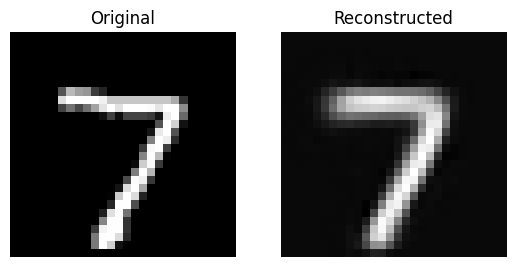

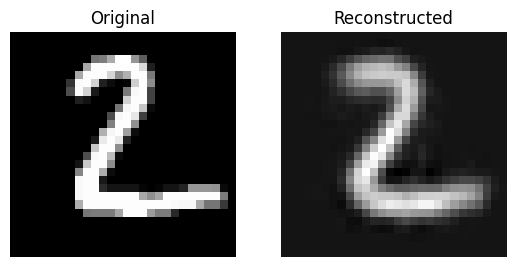

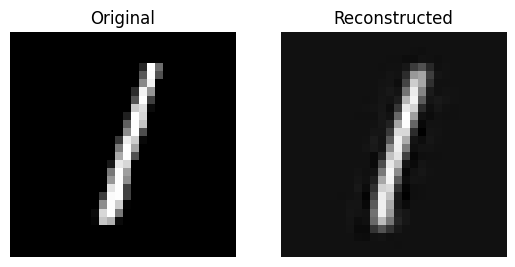

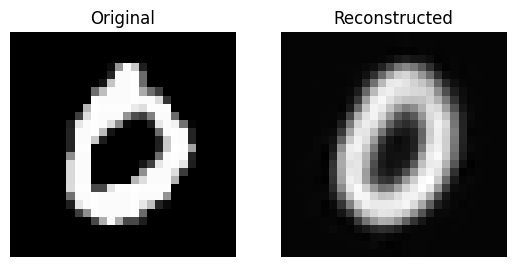

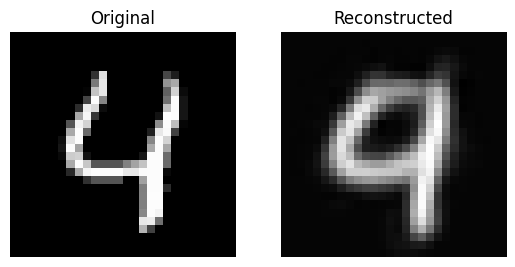

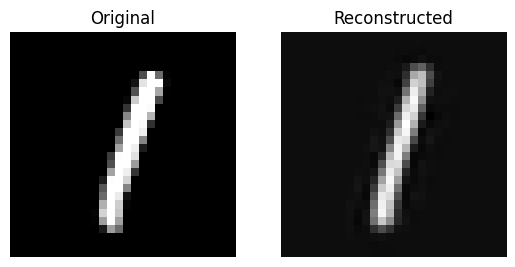

In [6]:
# Set the model to evaluation mode.
model.eval()

# Testing loop.
with torch.no_grad():
    test_loss = 0
    for test_data, _ in test_loader:
        # Move the test data to the specified device
        test_data = test_data.to(device)

        reconstructed_data = model(test_data)
        loss = mse_loss(reconstructed_data, test_data)
        test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    print(f"Average Test Loss: {average_test_loss:.4f}")

# Function to display original and reconstructed images.
def plot_images(original, reconstructed):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original[0][0].cpu().numpy(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(reconstructed[0][0].cpu().numpy(), cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

# Test the model on a few examples.
with torch.no_grad():
    for i, (test_data, _) in enumerate(test_loader):
        # Move the test data to the specified device.
        test_data = test_data.to(device)

        # Forward pass through the model.
        reconstructed_data = model(test_data)

        # Display the original and reconstructed images.
        plot_images(test_data, reconstructed_data)

        # Stop after displaying a few examples.
        if i == 5:
            break